# Project 1 – Decision Trees and Random Forests

#### Imports
Imports and random seed

In [46]:

import numpy as np
import matplotlib.pyplot as plt

from itertools import product
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from decision_tree import DecisionTree
from random_forest import RandomForest

# random seed
RANDOM_SEED = 21



### Load dataset

Loads letters.csv and divides into features (x) and lables (y). We also divide the dataset into test/train sets at a (80/20) ratio.

In [47]:
data = np.genfromtxt("letters.csv", delimiter=",", dtype=float, names=True)

feature_names = list(data.dtype.names[:-1])
target_name = data.dtype.names[-1]

X = np.array([data[f] for f in feature_names]).T
y = data[target_name].astype(int)

# 80/20 train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=0, shuffle=True, stratify=y
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"Feature columns names: {feature_names}")
print(f"Target column name: {target_name}")

X_train shape: (1600, 16), y_train shape: (1600,)
X_test shape: (400, 16), y_test shape: (400,)
Feature columns names: ['xbox', 'ybox', 'width', 'high', 'onpix', 'xbar', 'ybar', 'x2bar', 'y2bar', 'xybar', 'x2ybr', 'xy2br', 'xege', 'xegvy', 'yege', 'yegvx']
Target column name: label


### Hyperparameters

Sets up DecisionTree and RandomForest parameters for use in grid search.

In [48]:
dt_params = {
    "criterion": ["entropy", "gini"],
    "max_depth": [3, 5, 10, 15, None],
    "max_features": ["sqrt", "log2"],
}

rf_params = {
    "n_estimators": [20, 30, 40],
    "max_depth": [3, 5, 10, 15, None],
    "criterion": ["entropy", "gini"],
    "max_features": ["sqrt", "log2"],
}


### Cross-validation

Function for k-fold cross validation to calculate accuracy.

In [49]:
def cross_val_score(model_class, params, X, y, k=5, seed=RANDOM_SEED):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = model_class(**params)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        scores.append(accuracy_score(y_val, y_pred))
    return float(np.mean(scores))


### DecisionTree grid search

Tests combinations of hyperparameters to find optimal values for DecisionTree.

In [50]:
results_dt = []
best_dt_params = None
best_dt_score = -1.0

for criterion, max_depth, max_features in product(
    dt_params["criterion"], dt_params["max_depth"], dt_params["max_features"]
):
    params = {
        "criterion": criterion,
        "max_depth": max_depth,
        "max_features": max_features,
    }
    score = cross_val_score(
        DecisionTree, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_dt.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_dt_score:
        best_dt_score = mean_score
        best_dt_params = params

df_dt_results = pd.DataFrame(results_dt).sort_values(by="cv_score", ascending=False)

print("Best DecisionTree params:", best_dt_params)
print("Best DecisionTree 5-fold CV accuracy:", round(best_dt_score, 4))
df_dt_results.head()


Best DecisionTree params: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2'}
Best DecisionTree 5-fold CV accuracy: 0.8681


,criterion,max_depth,max_features,cv_score
19,gini,NaN,log2,0.868125
5,entropy,10.0,log2,0.866250
15,gini,10.0,log2,0.865000
8,entropy,NaN,sqrt,0.864375
16,gini,15.0,sqrt,0.857500


### RandomForest - grid Serach
Tests combinations of hyperparameters to find optimal values for RandomForest. (approx 6 min runtime)

In [51]:
results_rf = []
best_rf_params = None
best_rf_score = -1.0

for n_estimators, max_depth, criterion, max_features in product(
    rf_params["n_estimators"],
    rf_params["max_depth"],
    rf_params["criterion"],
    rf_params["max_features"],
):
    params = {
        "n_estimators": n_estimators,
        "max_depth": max_depth,
        "criterion": criterion,
        "max_features": max_features,
    }
    score = cross_val_score(
        RandomForest, params, X_train, y_train, k=5, seed=RANDOM_SEED
    )
    mean_score = np.mean(score)

    # lagre alle resultater
    results_rf.append({**params, "cv_score": mean_score})

    # oppdater best score
    if mean_score > best_rf_score:
        best_rf_score = mean_score
        best_rf_params = params

df_rf_results = pd.DataFrame(results_rf).sort_values(by="cv_score", ascending=False)

print("Best RandomForest params:", best_rf_params)
print("Best RandomForest 5-fold CV accuracy:", round(best_rf_score, 4))
df_rf_results.head()


Best RandomForest params: {'n_estimators': 40, 'max_depth': 15, 'criterion': 'gini', 'max_features': 'log2'}
Best RandomForest 5-fold CV accuracy: 0.9688


,n_estimators,max_depth,criterion,max_features,cv_score
55,40,15.0,gini,log2,0.968750
52,40,15.0,entropy,sqrt,0.965625
37,30,NaN,entropy,log2,0.965000
35,30,15.0,gini,log2,0.965000
36,30,NaN,entropy,sqrt,0.964375


## DecisionTree accuracy vs max_depth


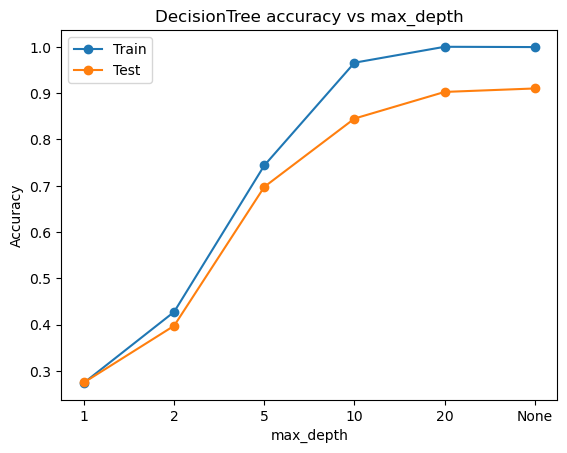

In [52]:
depths = [1, 2, 5, 10, 20, None]
train_scores = []
test_scores = []

for d in depths:
    model = DecisionTree(max_depth=d, criterion="gini", max_features="log2")
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot([str(d) for d in depths], train_scores, marker="o", label="Train")
plt.plot([str(d) for d in depths], test_scores, marker="o", label="Test")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("DecisionTree accuracy vs max_depth")
plt.legend()
plt.show()

## RandomForest accuracy vs n_estimator

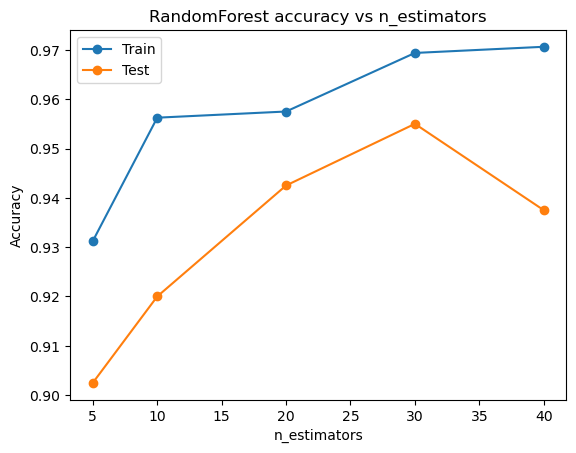

In [53]:
estimators = [5, 10, 20, 30, 40]
train_scores = []
test_scores = []

for n in estimators:
    model = RandomForest(n_estimators=n, max_depth=7, criterion="gini", max_features="log2")
    model.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, model.predict(X_train)))
    test_scores.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(estimators, train_scores, marker="o", label="Train")
plt.plot(estimators, test_scores, marker="o", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("RandomForest accuracy vs n_estimators")
plt.legend()
plt.show()

### Evaluation of grid search hyperparameters

We test the hyperparameters found by grid search on the full training set and evaluate on the test set.

In [54]:
# DecisionTree
dt_best = DecisionTree(**best_dt_params)
dt_best.fit(X_train, y_train)
dt_pred = dt_best.predict(X_test)
dt_acc = accuracy_score(y_test, dt_pred)

# RandomForest
rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)
rf_pred = rf_best.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)

# Print accuracy
print(f"DecisionTree test accuracy: {dt_acc:.4f}")
print(f"RandomForest test accuracy: {rf_acc:.4f}")


DecisionTree test accuracy: 0.8800
RandomForest test accuracy: 0.9800


### Evaluation of "non-overfitted" models

Instead of using the grid search hyperparameters, we use the parameter values based on our own analysis of the grid search results (argued in the rapport). Again, we use the full training set and evaluate on the test set. Cross validation is used to ensure a fair comparison to the grid search parameters. This test is done to get a comparason to our grid searched parameters.


In [55]:
# Curated DecisionTree
dt_manual_params = {
    "max_depth": 7,
    "criterion": "gini",
    "max_features": "log2",
}

dt_manual_cv = cross_val_score(
    DecisionTree, dt_manual_params, X_train, y_train, k=5, seed=RANDOM_SEED
)

print(f"DecisionTree (manual) 5-fold CV accuracy: {dt_manual_cv:.4f}")

dt_manual = DecisionTree(**dt_manual_params)
dt_manual.fit(X_train, y_train)
dt_manual_pred = dt_manual.predict(X_test)
dt_manual_acc = accuracy_score(y_test, dt_manual_pred)
print(f"DecisionTree (manual) test accuracy: {dt_manual_acc:.4f}")

# Curated RandomForest
rf_manual_params = {
    "n_estimators": 30,
    "max_depth": 7,
    "criterion": "gini",
    "max_features": "log2",
}

rf_manual_cv = cross_val_score(
    RandomForest, rf_manual_params, X_train, y_train, k=5, seed=RANDOM_SEED
)

print(f"RandomForest (manual) 5-fold CV accuracy: {rf_manual_cv:.4f}")

rf_manual = RandomForest(**rf_manual_params)
rf_manual.fit(X_train, y_train)
rf_manual_pred = rf_manual.predict(X_test)
rf_manual_acc = accuracy_score(y_test, rf_manual_pred)
print(f"RandomForest (manual) test accuracy: {rf_manual_acc:.4f}")

DecisionTree (manual) 5-fold CV accuracy: 0.8175
DecisionTree (manual) test accuracy: 0.8300
RandomForest (manual) 5-fold CV accuracy: 0.9325
RandomForest (manual) test accuracy: 0.9375


### SKLearn models

We train these models with the grid searched hyperparameters, as they yielded a higher test score for the Random Forest.

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Sklearn DecisionTree using best parameters
sk_dt_best = DecisionTreeClassifier(
    criterion=best_dt_params["criterion"],
    max_depth=best_dt_params["max_depth"],
    max_features=best_dt_params["max_features"],
    random_state=RANDOM_SEED
)
sk_dt_best.fit(X_train, y_train)
sk_dt_acc = accuracy_score(y_test, sk_dt_best.predict(X_test))

# Sklearn RandomForest using best parameters
sk_rf_best = RandomForestClassifier(
    n_estimators=best_rf_params["n_estimators"],
    max_depth=best_rf_params["max_depth"],
    criterion=best_rf_params["criterion"],
    max_features=best_rf_params["max_features"],
    random_state=RANDOM_SEED
)
sk_rf_best.fit(X_train, y_train)
sk_rf_acc = accuracy_score(y_test, sk_rf_best.predict(X_test))

# Print accuracy
print(f"Sklearn DecisionTree test accuracy: {sk_dt_acc:.4f}")
print(f"Sklearn RandomForest test accuracy: {sk_rf_acc:.4f}")


Sklearn DecisionTree test accuracy: 0.8975
Sklearn RandomForest test accuracy: 0.9875


## Runtime comparison for SK and our own model implementations.

In [62]:
import time
import pandas as pd

# DecisionTree
start = time.time()
dt_best.fit(X_train, y_train)
train_time_dt = time.time() - start

start = time.time()
_ = dt_best.predict(X_test)
pred_time_dt = time.time() - start

# RandomForest
start = time.time()
rf_best.fit(X_train, y_train)
train_time_rf = time.time() - start

start = time.time()
_ = rf_best.predict(X_test)
pred_time_rf = time.time() - start

# Sklearn DecisionTree
start = time.time()
sk_dt_manual.fit(X_train, y_train)
train_time_dt_sklearn = time.time() - start

start = time.time()
_ = sk_dt_manual.predict(X_test)
pred_time_dt_sklearn = time.time() - start

# Sklearn RandomForest
start = time.time()
sk_rf_manual.fit(X_train, y_train)
train_time_rf_sklearn = time.time() - start

start = time.time()
_ = sk_rf_manual.predict(X_test)
pred_time_rf_sklearn = time.time() - start

# Put results in a table
df_speed = pd.DataFrame({
    "DT": [train_time_dt, pred_time_dt],
    "Sklearn DT": [train_time_dt_sklearn, pred_time_dt_sklearn],
    "RF": [train_time_rf, pred_time_rf],
    "Sklearn RF": [train_time_rf_sklearn, pred_time_rf_sklearn],
}, index=["Train time (s)", "Predict time (s)"])

print(df_speed)


                        DT  Sklearn DT        RF  Sklearn RF
Train time (s)    0.137556    0.002041  3.923388    0.050551
Predict time (s)  0.000820    0.000257  0.034415    0.002230


#### Task 4 - Permutation Importance

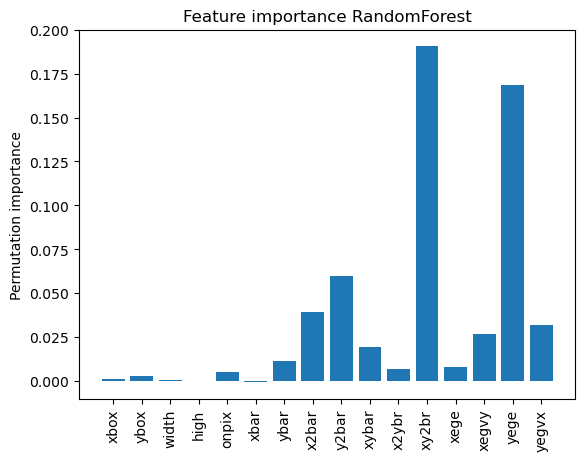

In [58]:
def permutation_importance(model, X, y, metric=accuracy_score, n_repeats=30, seed=RANDOM_SEED):
    rng = np.random.default_rng(seed)
    baseline = metric(y, model.predict(X))
    importances = []

    for col in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, col])
            score = metric(y, model.predict(X_permuted))
            scores.append(baseline - score)
        importances.append(np.mean(scores))
    return np.array(importances)

rf_best = RandomForest(**best_rf_params)
rf_best.fit(X_train, y_train)

importances = permutation_importance(rf_best, X_test, y_test, n_repeats=30, seed=RANDOM_SEED)

import matplotlib.pyplot as plt

plt.bar(range(len(feature_names)), importances)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.ylabel("Permutation importance")
plt.title("Feature importance RandomForest")
plt.show()
